In [12]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv
import math

import pymc  as pm
#from   pymc3.backends import SQLite
from   scipy  import optimize
from   aesara import tensor as tt

import matplotlib.pyplot as plt
import arviz as az

In [5]:
dat = pd.read_csv('data/sample_data_for_doug_defthresh_0.1.csv')
coverChange = dat['Canopy_cover_change'].values
Tchange = dat['T_change'].values

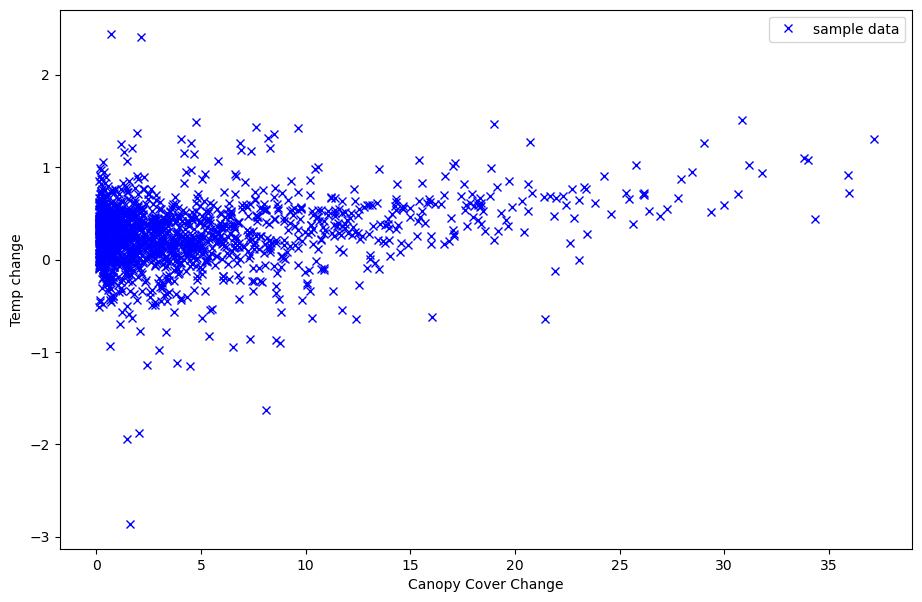

In [107]:
def scatter_data():
    fig = plt.figure(figsize=(11, 7))
    ax = fig.add_subplot(111, xlabel="Canopy Cover Change", ylabel="Temp change")
    ax.plot(coverChange, Tchange, "x", c = 'b', label="sample data")
    plt.legend(loc=0);
    return ax
    
ax = scatter_data()

In [10]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * coverChange, sigma=sigma, observed=Tchange)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, return_inferencedata=True)

/var/tmp/ipykernel_34623/1350002705.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


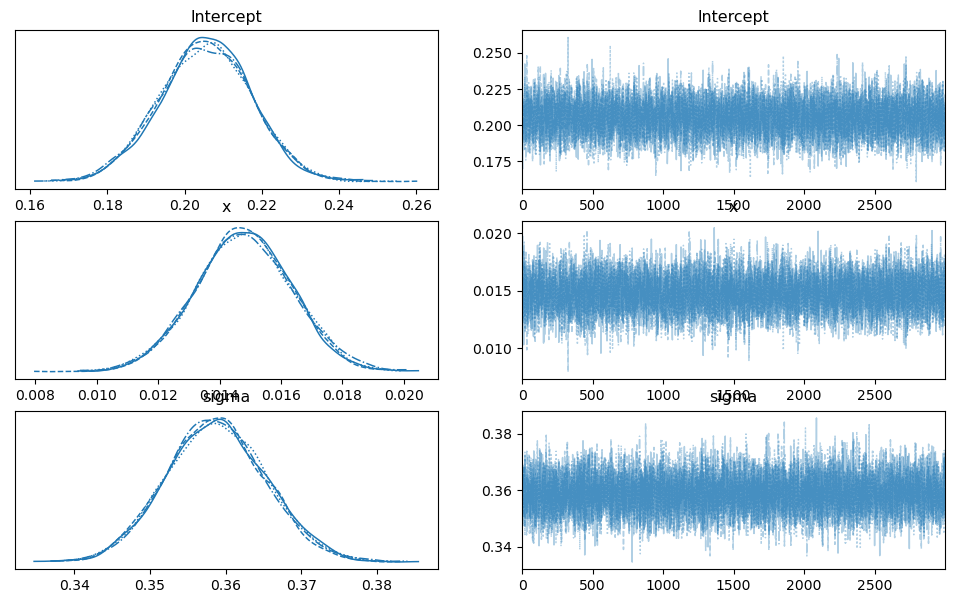

In [20]:
az.plot_trace(trace, figsize=(12, 7));

In [93]:
def select_post_param(name): return np.ndarray.flatten(trace.posterior[name].values)

def sample_model(i): 
        return select_post_param('Intercept')[i] + select_post_param('x')[i] *coverChange

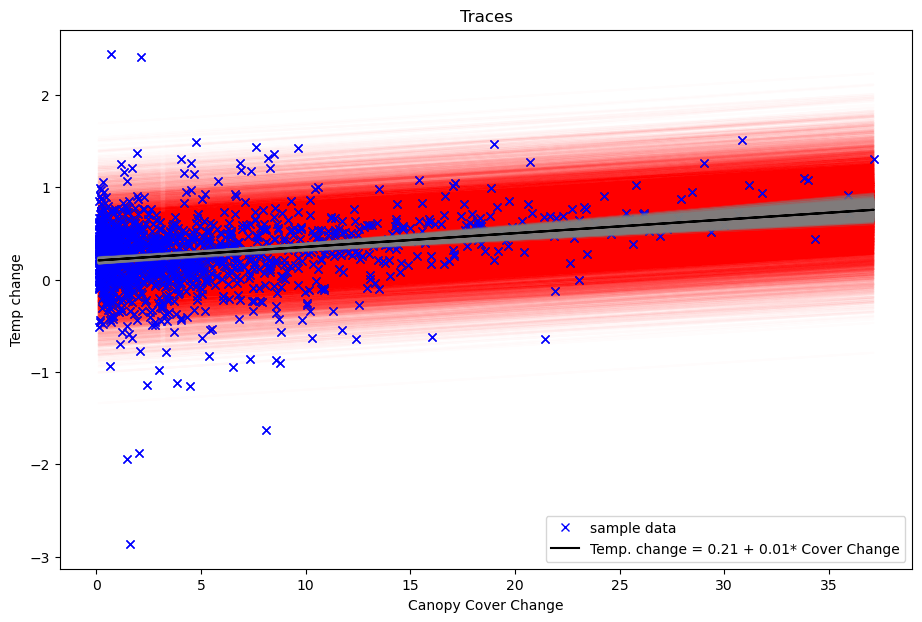

In [108]:
ax = scatter_data()
idx = range(0, len(select_post_param('Intercept')), 10)
intercept_m = select_post_param('Intercept').mean()
xcoeff_m = select_post_param('x').mean()

for i in idx:
    for noise in np.random.normal(0, select_post_param('sigma')[i], 10):
        plt.plot(coverChange, sample_model(i) + noise, c='red', alpha=0.01);

ax.plot(coverChange, Tchange, 'x', c = 'b')
for i in idx: plt.plot(coverChange, sample_model(i),c='gray', alpha=0.2);
    
plt.plot(coverChange, intercept_m + xcoeff_m * coverChange, c='k', label='Temp. change = {:.2f} + {:.2f}* Cover Change'.format(intercept_m, xcoeff_m))

plt.legend(loc=4)
plt.title("Traces")
plt.show()